2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 1

1 : ODE 4차 오차 감소율 없을때 출력

2 : ODE 5차 오차 감소율 없을때 출력

3 : ODE 4차 + EC Case1 w 계수들 exact 계수들과 일치하는 경우에 대해서 비교

2022-10-10

Exam 1

exp(-x)

Error, exact(4차, 5차), train(4차, 5차, 4차+EC Case1, Case2)

Module import

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [8]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y

def sigmoid(x):
    return tf.math.sigmoid(x)

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(tf.experimental.numpy.dot(x, W[0]))
    return tf.experimental.numpy.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return tf.experimental.numpy.dot(tf.experimental.numpy.dot(tf.transpose(W[1]), tf.transpose(W[0])**k), sigmoid_grad(x))

def net_out(W, x):
    return neural_network(W, x)

def EC_predict(W, x, n):
    return net_out(W, x)*x**(n+1)

def d_net_out(W, x):
    return d_neural_network_dx(W, x)

# 수정
def EC_d_y(W, x, n):
    return (n+1)*net_out(W, x)*x**n + d_net_out(W, x)*x**(n+1)

ODE

n : 차수

target_loss : 이전 학습 loss_sum의 차가 target_loss 보다 작으면 멈춤

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [9]:
def ODE_train(n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]

    # 변화 w 값, loss 저장
    w_trace = []
    w_trace.append(w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                predict = f(y(x_unit, w, n), lamb)
                # y' = f(y, t)
                loss = tf.square(predict - yprime(x_unit, w, n))
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, w)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients], [w]))
        
        # w 변화값 저장
        w_trace.append(w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        ax.plot(y(x, early_stop_w, n), label = 'y')
        # ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

ODE + EC

n : 차수

EC_n : EC weight 개수 (가로, 세로 두 곳 다 적용)

target_loss : loss_sum이 target_loss 보다 작아지면 early_stop 조건에 들어간다. 

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [10]:
def ODE_EC_Case1_train(n = 4, EC_n = 10, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[1, EC_n], [EC_n, 1]]
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

    # 변화 w 값, loss 저장
    w_trace = [np.append(np.array(w.numpy()), net_out(W, x[0]).numpy())]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n) + EC_predict(W, x_unit, n)
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, w, n) + EC_d_y(W, x_unit, n)
                # y' = f(y, t)
                loss = tf.square(predict - y_prime)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_gradients] = tape.gradient(loss, [w, W])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
            
        # w 변화값 저장
        total_w = np.append(np.array(w.numpy()), net_out(W, x_unit).numpy())
        w_trace.append(total_w)

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)] + ['NN'])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

In [11]:
def ODE_EC_Case2_train(n = 4, EC_n = 10, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[1, EC_n], [EC_n, 1]]
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

    # 변화 w 값, loss 저장
    w_trace = [np.append(np.array(w.numpy()), net_out(W, x[0]).numpy())]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n)
                EC = f(EC_predict(W, x_unit, n), lamb)
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, w, n)
                d_EC = EC_d_y(W, x_unit, n)
                # y' = f(y, t)
                loss = tf.square(predict - yprime(x_unit, w, n)) + tf.square(EC - d_EC)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_gradients] = tape.gradient(loss, [w, W])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
            
        # w 변화값 저장
        total_w = np.append(np.array(w.numpy()), net_out(W, x_unit).numpy())
        w_trace.append(total_w)

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)] + ['NN'])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

Train

----------------------------------

Epoch : 100, Loss_sum : 12.0327, w : [-0.36707982 -0.52912    -0.70013493  0.97387785]
Epoch : 200, Loss_sum : 1.6213, w : [-0.7682525  0.2941566 -0.5275384  0.3847301]
Epoch : 300, Loss_sum : 0.0064, w : [-1.0264208   0.64661205 -0.38525844  0.1310307 ]
Epoch : 400, Loss_sum : 0.0007, w : [-1.0081846   0.55100375 -0.2618611   0.08269919]
Epoch : 500, Loss_sum : 0.0001, w : [-0.9925999   0.5280784  -0.19284771  0.03456468]
Epoch : 600, Loss_sum : 0.0002, w : [-0.99628884  0.49255356 -0.15868744  0.03011203]
Epoch : 700, Loss_sum : 0.0000, w : [-0.99921274  0.5115297  -0.1604755   0.02112703]
Epoch : 800, Loss_sum : 0.0000, w : [-1.0002141   0.4958054  -0.15090838  0.02355855]
Epoch : 900, Loss_sum : 0.0010, w : [-0.99815464  0.4881193  -0.15699878  0.03267838]
Epoch : 1000, Loss_sum : 0.0003, w : [-0.9951815   0.49019223 -0.15892895  0.03107561]
Epoch : 1100, Loss_sum : 0.0000, w : [-0.9974904   0.49949905 -0.16532813  0.03168781]
Epoch : 1200, Loss_sum : 0.0001, w : [-1.0033772   0.50

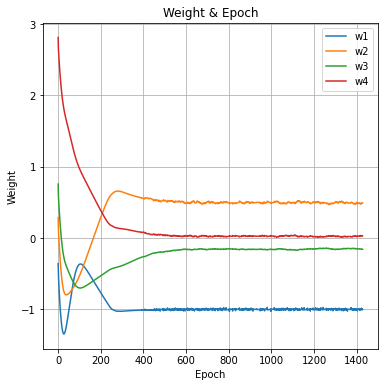

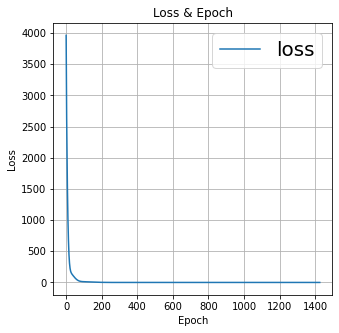

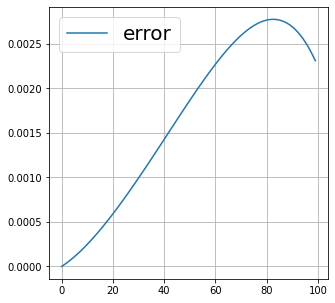

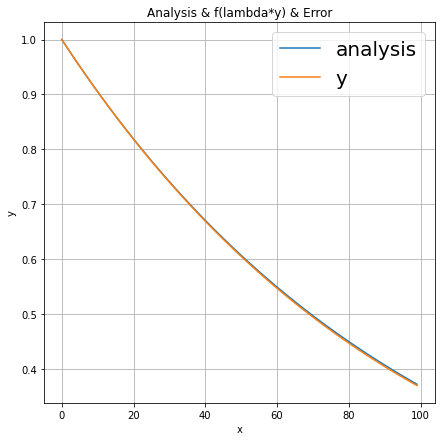

In [12]:
w4_train = ODE_train(n = 4, early_stop = 500)

Epoch : 100, Loss_sum : 1.1477, w : [-0.7156807  -0.6777322   0.8966388   0.2915445  -0.45172793]
Epoch : 200, Loss_sum : 0.7901, w : [-0.76731    -0.4620411   0.7079499   0.15383653 -0.28649998]
Epoch : 300, Loss_sum : 0.2407, w : [-8.5924691e-01 -1.4982595e-01  5.7018888e-01 -7.2131952e-05
 -1.8886314e-01]
Epoch : 400, Loss_sum : 0.0639, w : [-0.92385024  0.0990902   0.3821172  -0.14918745 -0.03938581]
Epoch : 500, Loss_sum : 0.0059, w : [-0.9733042   0.31718084  0.20619689 -0.26123708  0.07962882]
Epoch : 600, Loss_sum : 0.0011, w : [-0.9907223   0.42273703  0.11622263 -0.28602928  0.11218342]
Epoch : 700, Loss_sum : 0.0011, w : [-0.9863415   0.4036496   0.08254939 -0.26972422  0.13106288]
Epoch : 800, Loss_sum : 0.0016, w : [-1.0010008   0.42034796  0.09693417 -0.2603233   0.11057796]
Epoch : 900, Loss_sum : 0.0010, w : [-0.9780913   0.41997892  0.0782792  -0.254276    0.10971162]
Epoch : 1000, Loss_sum : 0.0008, w : [-0.97845465  0.41564292  0.0638924  -0.2412425   0.1106709 ]
Epo

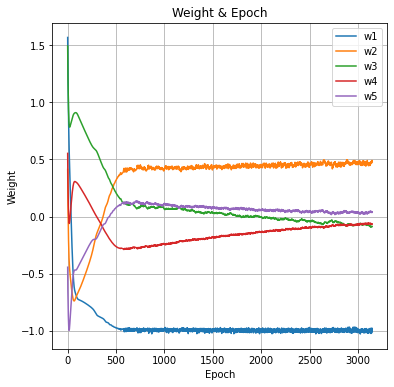

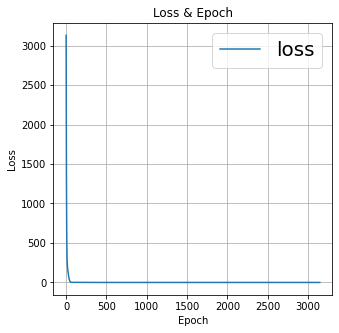

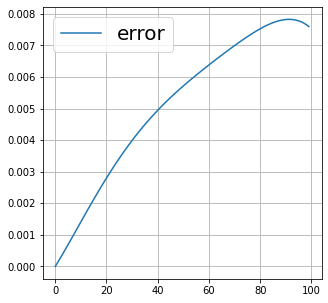

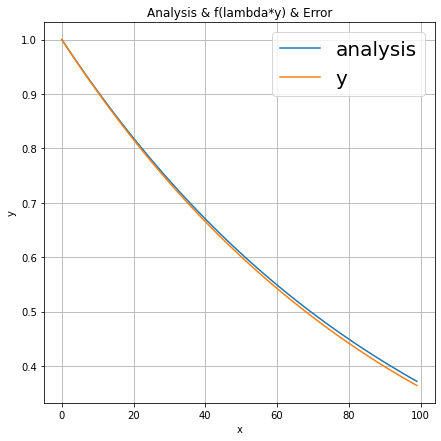

In [13]:
w5_train = ODE_train(n = 5, early_stop = 500)

Epoch : 100, Loss_sum : 0.3155, w : [-0.88332075  0.19913669 -0.4383457   0.9040592  -0.44502437]
Epoch : 200, Loss_sum : 0.0025, w : [-0.99096113  0.5130479  -0.46763897  0.78983325 -0.5182393 ]
Epoch : 300, Loss_sum : 0.0004, w : [-1.0044956   0.5744996  -0.48564363  0.7648447  -0.5272759 ]
Epoch : 400, Loss_sum : 0.0011, w : [-1.0044681   0.58245844 -0.48422307  0.75920355 -0.53185576]
Epoch : 500, Loss_sum : 0.0008, w : [-0.9990685   0.56205267 -0.4631513   0.76290715 -0.54195106]
Epoch : 600, Loss_sum : 0.0007, w : [-0.9995943   0.56118476 -0.4449981   0.7612536  -0.5567882 ]
Epoch : 700, Loss_sum : 0.0002, w : [-1.0073037   0.5618197  -0.427978    0.7617617  -0.56846684]
Epoch : 800, Loss_sum : 0.0024, w : [-1.0112762   0.5498722  -0.3980295   0.770535   -0.58441687]
Epoch : 900, Loss_sum : 0.0001, w : [-1.0028183   0.5387924  -0.40025708  0.76619077 -0.57970583]
Epoch : 1000, Loss_sum : 0.0015, w : [-0.98424065  0.5401659  -0.36269152  0.7882887  -0.6105723 ]
Epoch : 1100, Loss_

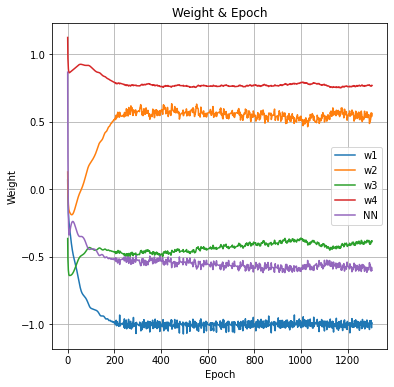

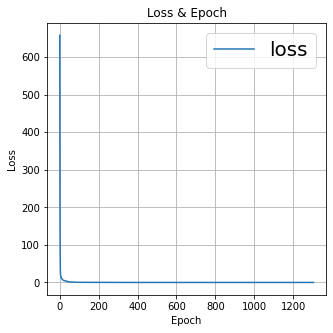

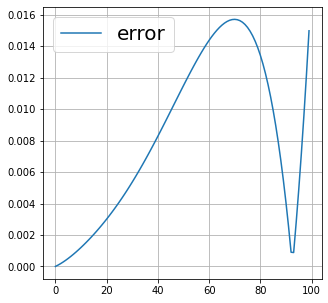

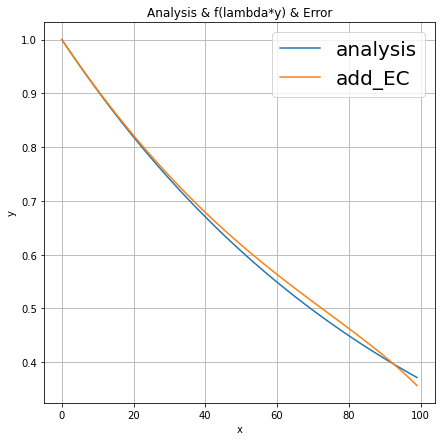

In [14]:
w4_EC_Case1_train = ODE_EC_Case1_train(n = 4, EC_n = 10, early_stop = 500)

In [15]:
w4_EC_Case2_train = ODE_EC_Case2_train(n = 4, EC_n = 10, early_stop = 500)

Epoch : 100, Loss_sum : 0.1715, w : [-1.0933057   1.0814308  -1.0167413   0.40338722  0.02256319]
Epoch : 200, Loss_sum : 0.0778, w : [-1.0850642   0.96468246 -0.8539599   0.33797613  0.01583329]
Epoch : 300, Loss_sum : 0.0388, w : [-1.0594019   0.8369859  -0.66744727  0.25508758  0.01243699]
Epoch : 400, Loss_sum : 0.0116, w : [-1.0340211   0.70866495 -0.4861935   0.17722261  0.01549059]
Epoch : 500, Loss_sum : 0.0022, w : [-1.0151106   0.59981924 -0.322579    0.10410461  0.01882064]
Epoch : 600, Loss_sum : 0.0064, w : [-0.9892288   0.5486995  -0.22935808  0.04994656  0.00246167]
Epoch : 700, Loss_sum : 0.0003, w : [-1.0001931   0.51021975 -0.18258454  0.04011131  0.01644042]


In [ ]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인

# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

# 2022.08.23
# x 범위 증가 대신 개수 증가로 0 ~ 1 사이
# 코드 공유
# Error 파트 layer 추가
# Solution + Error
##  추가 학습 필요 내용 ## 
# Error에 따른 weight 업데이트 과정 수식 확인
# 비지도 학습 진행과정


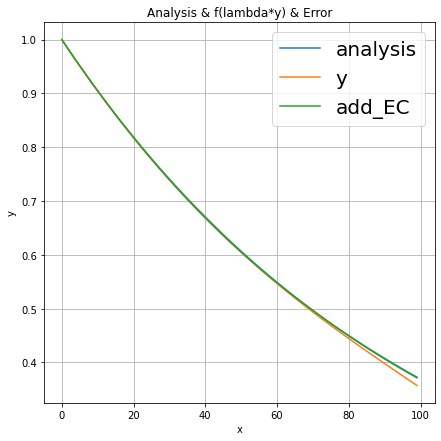

In [ ]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

w, W = w4_EC_Case1_train

n = 4

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, w, n), label = 'y')
ax.plot(y(x, w, n)  + EC_predict(W, x, n), label = 'add_EC')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

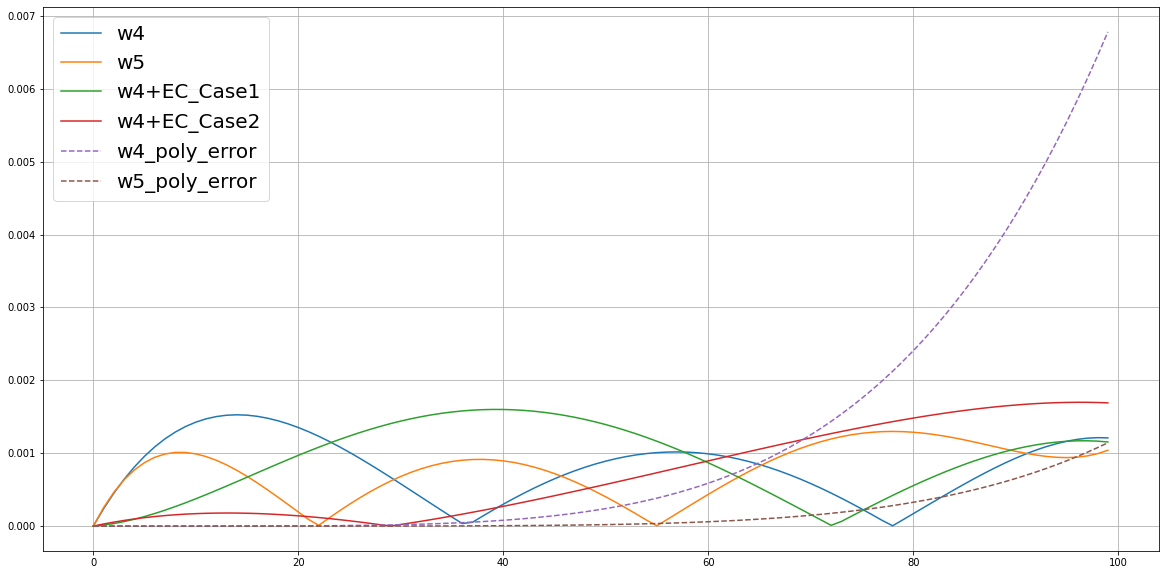

In [ ]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0
n = 4

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(abs(y(x, w4_train, 4) - anal(x,lamb)), label = 'w4')
ax.plot(abs(y(x, w5_train, 5) - anal(x,lamb)), label = 'w5')
ax.plot(abs(y(x, w4_EC_Case1_train[0], 4) + EC_predict(w4_EC_Case1_train[1], x, n) - anal(x,lamb)), label = 'w4+EC_Case1')
ax.plot(abs(y(x, w4_EC_Case2_train[0], 4) + EC_predict(w4_EC_Case2_train[1], x, n) - anal(x,lamb)), label = 'w4+EC_Case2')
ax.plot(abs(y(x, poly_w[:4], 4) - anal(x,lamb)), '--', label = 'w4_poly_error')
ax.plot(abs(y(x, poly_w[:5], 5) - anal(x,lamb)), '--', label = 'w5_poly_error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()